In [7]:
from IPython.display import HTML
from IPython.display import display
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as dat
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import warnings
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

In [8]:
#importing of datasets
load = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "load", index_col = 0)
temp = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "historical temperature", index_col = 0)
sun = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "sunshine duration", index_col = 0)
covid = pd.read_csv("covid-stringency-index.csv")
#cleaning covid datset: 
coviduk = covid[covid['Entity']== 'United Kingdom' ]
coviduk = coviduk.set_index('Date')
#join covid with sun dataset
sun_covid = sun.join(coviduk, lsuffix='_caller', rsuffix='_other')

sun_covid = sun_covid.drop(columns=['Entity', 'Code'])
#replace NaN with 0 (i.e. no covid means 0 stringency index)
sun_covid['stringency_index'] = sun_covid['stringency_index'].fillna(0)
#drop column in temp
temp = temp.drop(columns=['Unnamed: 4', '(every 6 hours - 6am/12/6pm/24)'])
#rename column
load.columns = ['value']

Approach: 
1. taking weighted average of sun 
2. taking weighted average of temperature 
3. creating covid dummy with stringency index
4. build regression with: 
    - autoregression
    - seasonality index 
    - quadratic term
    - stringency
    - temperature
    - sunlight 
    - day of week?
    - month 
look into not weighting sun power 

In [9]:
sun_covid.tail()

,Bristol,Leeds,London,stringency_index
2021-03-04,157.38028,134.61206,0.00000,0.0
2021-03-05,661.97906,247.85887,511.66028,0.0
2021-03-06,475.62286,540.63434,381.67856,0.0
2021-03-07,683.31670,650.92270,616.58380,0.0
2021-03-08,313.60535,85.22076,160.85106,0.0


In [10]:
coviduk.tail()

,Entity,Code,stringency_index
Date,,,
2021-02-22,United Kingdom,GBR,87.96
2021-02-23,United Kingdom,GBR,87.96
2021-02-24,United Kingdom,GBR,87.96
2021-02-25,United Kingdom,GBR,87.96
2021-02-26,United Kingdom,GBR,87.96


In [11]:
load.tail()

,value
Date,
2021-03-03,31165.583333
2021-03-04,30915.812500
2021-03-05,30367.833333
2021-03-06,27862.083333
2021-03-07,27075.104170


In [12]:
temp.tail(n=10)

,London,Leeds,Bristol
2021-03-07 12:00:00,4.506411,5.906828,4.840105
2021-03-07 18:00:00,6.546411,9.126828,6.700105
2021-03-08 00:00:00,4.106412,2.916829,2.910105
2021-03-08 06:00:00,1.386411,3.606829,1.050105
2021-03-08 12:00:00,7.646411,8.596828,7.900105
2021-03-08 18:00:00,10.096412,8.886828,8.690105
2021-03-09 00:00:00,5.000000,5.000000,3.000000
2021-03-09 00:00:00,2.000000,6.000000,3.000000
2021-03-09 00:00:00,7.000000,8.000000,8.000000
2021-03-09 00:00:00,8.000000,7.000000,5.000000


In [13]:
print(temp.columns.tolist())

['London ', 'Leeds ', 'Bristol']


In [14]:
print(sun.columns.tolist())

['Bristol', 'Leeds', 'London']


In [15]:
temp['London ']

2017-01-01 00:00:00     7.700105
2017-01-01 06:00:00     7.460105
2017-01-01 12:00:00     5.160105
2017-01-01 18:00:00     5.340105
2017-01-02 00:00:00     1.800105
                         ...    
2021-03-08 18:00:00    10.096412
2021-03-09 00:00:00     5.000000
2021-03-09 00:00:00     2.000000
2021-03-09 00:00:00     7.000000
2021-03-09 00:00:00     8.000000
Name: London , Length: 6116, dtype: float64

In [16]:
#weighted averate 
#population per city: 
london = 8982000
leeds = 792525
bristol = 467099
total = london + leeds + bristol
london = london/total
leeds = leeds/total
bristol = bristol/total
#average for sun 
L = []
for i, bris in enumerate(sun_covid['Bristol']): 
    avg = bris*bristol + sun_covid['Leeds'][i] * leeds + sun_covid['London'][i] * london
    L.append(avg)
sun_covid['avg_sun'] = L

#average temperature (how did you guys remove the spaces?)
L = []
for i, bris in enumerate(temp['Bristol']): 
    avg = bris*bristol + temp['Leeds '][i] * leeds + temp['London '][i] * london
    L.append(avg)
temp['avg_temp'] = L

#bring temp to day level 
temp=temp.groupby(pd.Grouper(freq="1D")).mean()

#join all tabels to for regression 
fulldf = temp.join(sun_covid, lsuffix='_temp', rsuffix='_sun')
fulldf = fulldf.drop(columns=['Bristol_temp','London ','London','Leeds ','Bristol_sun','Leeds'])
fulldf = fulldf.join(load, lsuffix='_caller', rsuffix='_other')
#replace na with 0 
fulldf = fulldf.fillna(0)
fulldf['avg_sun'][-1] = fulldf['avg_sun'][-2]
fulldf['stringency_index'][-11:] = fulldf['stringency_index'][-12] 
print(fulldf.columns.tolist())
fulldf

['avg_temp', 'stringency_index', 'avg_sun', 'value']


,avg_temp,stringency_index,avg_sun,value
2017-01-01,6.250532,0.00,23.111048,27079.979170
2017-01-02,2.751850,0.00,476.499201,29568.083330
2017-01-03,2.995515,0.00,231.847972,34100.541670
2017-01-04,5.399957,0.00,310.776818,34647.020830
2017-01-05,1.591394,0.00,460.974889,36120.770830
...,...,...,...,...
2021-03-05,4.002804,87.96,498.102327,30367.833333
2021-03-06,3.515665,87.96,398.263598,27862.083333
2021-03-07,3.425901,87.96,622.284586,27075.104170
2021-03-08,5.793223,87.96,161.965383,0.000000


,avg_temp,stringency_index,avg_sun,value
2017-01-01,6.250532,0.00,23.111048,27079.979170
2017-01-02,2.751850,0.00,476.499201,29568.083330
2017-01-03,2.995515,0.00,231.847972,34100.541670
2017-01-04,5.399957,0.00,310.776818,34647.020830
2017-01-05,1.591394,0.00,460.974889,36120.770830
...,...,...,...,...
2021-03-05,4.002804,87.96,498.102327,30367.833333
2021-03-06,3.515665,87.96,398.263598,27862.083333
2021-03-07,3.425901,87.96,622.284586,27075.104170
2021-03-08,5.793223,87.96,161.965383,0.000000


In [17]:

#add autoregressive terms
fulldf["values-1"] = fulldf["value"].shift()
fulldf["values-7"] = fulldf["value"].shift(periods=7)
#add month dummy 
fulldf['month']=fulldf.index.month
#squared term 
fulldf['quadratic'] = fulldf['values-7']**2
fulldf.tail() 

,avg_temp,stringency_index,avg_sun,value,values-1,values-7,month,quadratic
2021-03-05,4.002804,87.96,498.102327,30367.833333,30915.812500,27969.895833,3,7.823151e+08
2021-03-06,3.515665,87.96,398.263598,27862.083333,30367.833333,25298.541667,3,6.400162e+08
2021-03-07,3.425901,87.96,622.284586,27075.104170,27862.083333,25294.750000,3,6.398244e+08
2021-03-08,5.793223,87.96,161.965383,0.000000,27075.104170,29467.750000,3,8.683483e+08
2021-03-09,5.543177,87.96,161.965383,0.000000,0.000000,30112.625000,3,9.067702e+08


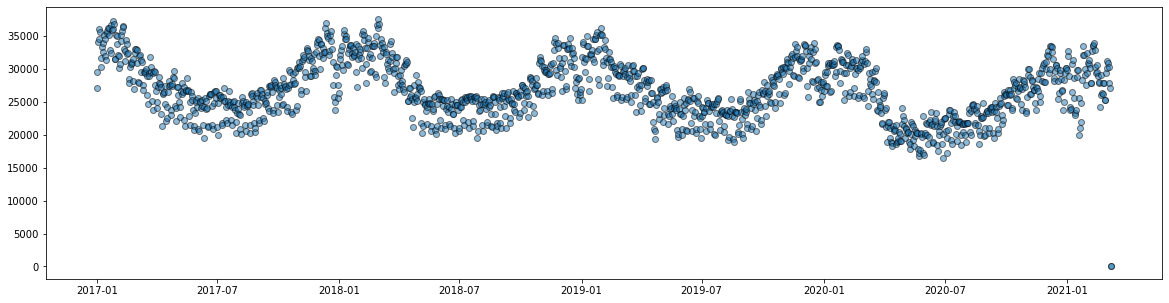

In [18]:
plt.figure(figsize = (20,5))
plt.scatter(fulldf.index,fulldf['value'], edgecolor='k',  alpha = 0.5)

Text(0.5, 1.0, 'covid')

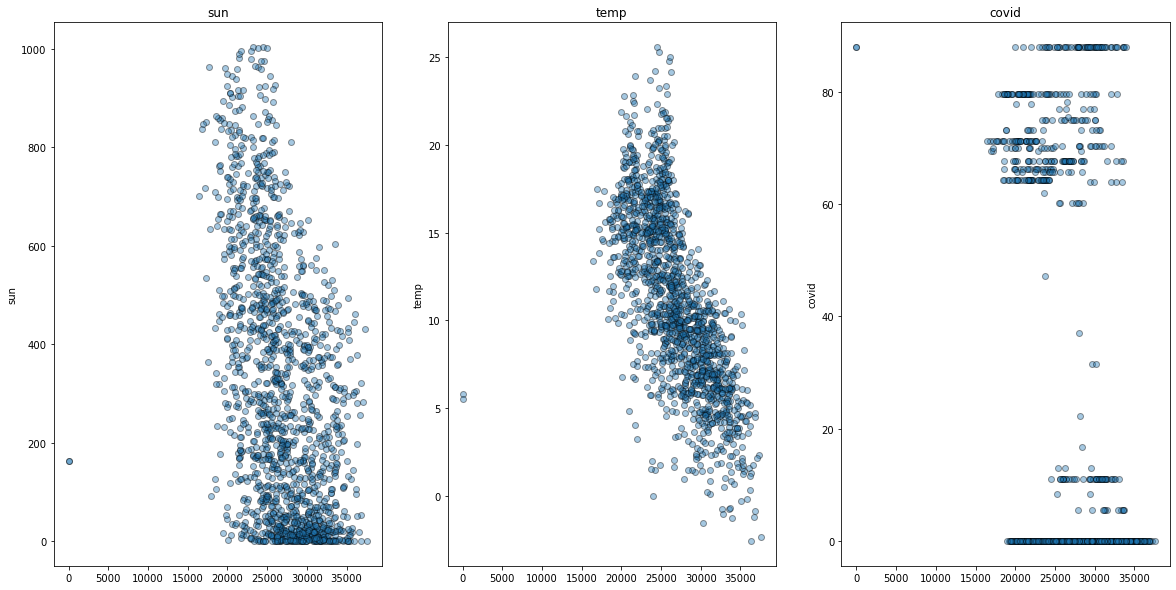

In [19]:
#plot relationship of variables 
fig, ax = plt.subplots(1,3, figsize =(20,10))
#plot the normalized data and give color depending on label 
ax[0].scatter(fulldf['value'],fulldf['avg_sun'], edgecolor='k',  alpha = 0.4)
ax[1].scatter(fulldf['value'],fulldf['avg_temp'], edgecolor='k',  alpha = 0.4)
ax[2].scatter(fulldf['value'],fulldf['stringency_index'], edgecolor='k',  alpha = 0.4)
              
ax[0].set_ylabel("sun")  
ax[1].set_ylabel("temp")  
ax[2].set_ylabel("covid") 

ax[0].set_title("sun")  
ax[1].set_title("temp")  
ax[2].set_title("covid")

In [20]:
# dependent vs indipendent variable 
Y = fulldf['value']
X = fulldf.drop(columns=['value'])
#remove last value of dataframe since it includes NaN
X = X.iloc[7:-1]
Y = Y.iloc[7:-1]
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

In [21]:
X_test

,avg_temp,stringency_index,avg_sun,values-1,values-7,month,quadratic
2021-03-08,5.793223,87.96,161.965383,27075.10417,29467.75000,3,8.683483e+08
2019-11-25,10.608697,0.00,0.727784,28614.62500,31913.31250,11,1.018460e+09
2018-02-02,4.516076,0.00,433.348660,32586.56250,33764.60417,2,1.140048e+09
2019-04-25,9.726626,0.00,569.581428,25834.58333,24991.00000,4,6.245501e+08
2017-05-19,11.135313,0.00,182.830764,26898.33333,27290.97917,5,7.447975e+08
...,...,...,...,...,...,...,...
2017-06-07,13.113507,0.00,658.549241,24994.14583,25251.87500,6,6.376572e+08
2017-08-15,16.414979,0.00,436.104997,25038.27083,25696.50000,8,6.603101e+08
2017-12-07,9.233902,0.00,140.811086,32364.97917,34515.22917,12,1.191301e+09
2018-04-02,9.190091,0.00,7.510755,26945.89583,30170.58333,4,9.102641e+08


In [22]:
Y.tail()

2021-03-04    30915.812500
2021-03-05    30367.833333
2021-03-06    27862.083333
2021-03-07    27075.104170
2021-03-08        0.000000
Freq: D, Name: value, dtype: float64

In [23]:
#regression model 
lin_reg_mod = LinearRegression()
#fit the regression model training set
lin_reg_mod.fit(X_train, y_train)
#predict on the test set 
pred = lin_reg_mod.predict(X_test)
# check accuracy against 
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
print("Root Mean Square Error:\n")
print(test_set_rmse)

Root Mean Square Error:

2280.0433476890294


In [24]:
lin_reg_mod.coef_

array([-1.02716413e+02, -5.62705832e+00, -1.08978651e+00,  3.91648614e-01,
        7.45905164e-01,  3.24643776e+00, -5.43159716e-06])

In [25]:
#prepare dataframes to be dropped 
pred = pd.DataFrame(data = pred)
y_test.reset_index(drop=True, inplace=True) 

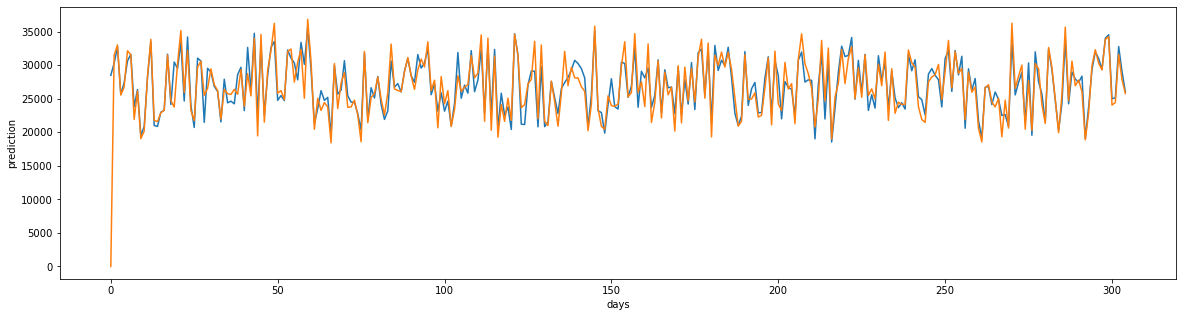

In [26]:
plt.figure(figsize = (20,5))
plt.plot(pred)
plt.plot(y_test)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

In [27]:
# neural network model  (https://towardsdatascience.com/predicting-sales-611cb5a252de) 

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

In [29]:
#add specific features for NN model
#add month dummy 
fulldf['day']=fulldf.index.day
#autoregression term for days 1-7, one for 2 weeks and one for 1 month 
fulldf["values-2"] = fulldf["value"].shift(periods=2)
fulldf["values-3"] = fulldf["value"].shift(periods=3)
fulldf["values-4"] = fulldf["value"].shift(periods=4)
fulldf["values-5"] = fulldf["value"].shift(periods=5)
fulldf["values-6"] = fulldf["value"].shift(periods=6)
fulldf["values-14"] = fulldf["value"].shift(periods=14)
fulldf["values-30"] = fulldf["value"].shift(periods=30)
#fulldf["values-365"] = fulldf["value"].shift(periods=365)

In [57]:
norm_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2017-01-01,-0.954610,-0.561487,-1.101345,0.071062,NaN,NaN,-1.508155,NaN,-1.663485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,-1.641996,-0.561487,0.627956,0.643056,0.067859,NaN,-1.508155,NaN,-1.549933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,-1.594123,-0.561487,-0.305186,1.685030,0.646887,NaN,-1.508155,NaN,-1.436380,0.064583,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,-1.121723,-0.561487,-0.004138,1.810661,1.701675,NaN,-1.508155,NaN,-1.322827,0.650931,0.064603,NaN,NaN,NaN,NaN,NaN
2017-01-05,-1.869991,-0.561487,0.568744,2.149463,1.828851,NaN,-1.508155,NaN,-1.209274,1.719055,0.650761,0.064746,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-05,-1.396221,2.250815,0.710354,0.826912,0.960529,0.276167,-0.939833,0.199742,-1.209274,1.027400,0.779046,0.627094,-0.355111,-0.353575,0.305676,0.951360
2021-03-06,-1.491929,2.250815,0.329552,0.250861,0.833004,-0.352906,-0.939833,-0.415545,-1.095721,0.968538,1.027106,0.778970,0.627584,-0.354468,-0.599169,1.092496
2021-03-07,-1.509566,2.250815,1.184007,0.069942,0.249869,-0.353799,-0.939833,-0.416374,-0.982169,0.839401,0.968264,1.026954,0.779445,0.628207,-0.167250,0.815409
2021-03-08,-1.044458,2.250815,-0.571730,-6.154394,0.066724,0.628894,-0.939833,0.571742,-0.868616,0.248894,0.839169,0.968130,1.027404,0.780065,0.562680,0.264429


In [59]:
#normalize features
#remove first 30 values of dataframe since it includes NaN
df_adjusted = fulldf.iloc[30:]

#split dataset
X_train, X_test, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 0.2, shuffle=False)

train_index = X_train.index
col=X_train.columns
test_index = X_test.index

scaler_x = preprocessing.StandardScaler()
scaler_y= preprocessing.StandardScaler()

X_train=scaler_x.fit_transform(X_train.values)
y_train=scaler_y.fit_transform(y_train.values.reshape(-1,1))
X_test=scaler_x.transform(X_test.values)
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

X_train = pd.DataFrame(X_train, columns=col, index=train_index)
X_test = pd.DataFrame(X_test, columns=col, index=test_index)

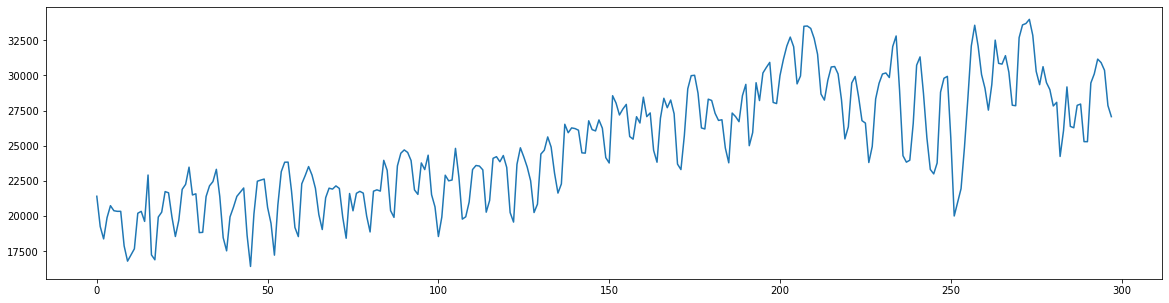

In [63]:
#plot the y test dataset 
test = scaler_y.inverse_transform(y_test[:-2])
plt.figure(figsize = (20,5))
plt.plot(test)

In [33]:
#run neural network model 
regr = MLPRegressor(hidden_layer_sizes = (112) ,validation_fraction = 0, max_iter=10000).fit(X_train, y_train)
#drop index
y_test.reset_index(drop=True, inplace=True) 

In [53]:
norm_final 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2017-01-01,-0.954610,-0.561487,-1.101345,0.071062,NaN,NaN,-1.508155,NaN,-1.663485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,-1.641996,-0.561487,0.627956,0.643056,0.067859,NaN,-1.508155,NaN,-1.549933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,-1.594123,-0.561487,-0.305186,1.685030,0.646887,NaN,-1.508155,NaN,-1.436380,0.064583,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,-1.121723,-0.561487,-0.004138,1.810661,1.701675,NaN,-1.508155,NaN,-1.322827,0.650931,0.064603,NaN,NaN,NaN,NaN,NaN
2017-01-05,-1.869991,-0.561487,0.568744,2.149463,1.828851,NaN,-1.508155,NaN,-1.209274,1.719055,0.650761,0.064746,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-05,-1.396221,2.250815,0.710354,0.826912,0.960529,0.276167,-0.939833,0.199742,-1.209274,1.027400,0.779046,0.627094,-0.355111,-0.353575,0.305676,0.951360
2021-03-06,-1.491929,2.250815,0.329552,0.250861,0.833004,-0.352906,-0.939833,-0.415545,-1.095721,0.968538,1.027106,0.778970,0.627584,-0.354468,-0.599169,1.092496
2021-03-07,-1.509566,2.250815,1.184007,0.069942,0.249869,-0.353799,-0.939833,-0.416374,-0.982169,0.839401,0.968264,1.026954,0.779445,0.628207,-0.167250,0.815409
2021-03-08,-1.044458,2.250815,-0.571730,-6.154394,0.066724,0.628894,-0.939833,0.571742,-0.868616,0.248894,0.839169,0.968130,1.027404,0.780065,0.562680,0.264429


In [34]:
#predition of day -2 
X_test_2 = X_test.iloc[-2].values.reshape(1,-1)
nn_pred_2 = regr.predict(X_test_2)
pred_2 = nn_pred_2 * (min_max_scaler.var_[3])**(1/2) + min_max_scaler.mean_[3]
#add value -2 to the dataset
X_test[4][-1]= nn_pred_2
#prediction -1
X_test_1 = X_test.iloc[-1].values.reshape(1,-1)
nn_pred_1 = regr.predict(X_test_1)
#scale back 
pred_1=nn_pred_1 * (min_max_scaler.var_[3])**(1/2) + min_max_scaler.mean_[3]


print(pred_2)
print(math.log(pred_2))
print(pred_1)
print(math.log(pred_1))

[27059.91874147]
10.205808898818358
[26329.25948184]
10.178436127591866


In [51]:
#get the full test set performance 
nn_pred_full = regr.predict(X_test)
#accuracy of the model 
predicted = nn_pred_full * (min_max_scaler.var_[3])**(1/2) + min_max_scaler.mean_[3]
predicted = [math.log(i) if i>0 else 0 for i in predicted]
actuals = y_test * (min_max_scaler.var_[3])**(1/2) + min_max_scaler.mean_[3]
actuals = [math.log(i) if i>0 else 0 for i in actuals]
#accuracy of the model 
MSE = mean_squared_error(actuals[-2:], predicted[-2:])
RMSE = math.sqrt(MSE)
#print("Root Mean Square Error:\n")
#print(RMSE)
#math.log(np.std(actuals-predicted)) 
print(np.std(np.array(actuals[-2:]) - np.array(predicted[-2:])))

0.013686385613246088


In [50]:
#plot real values 
predicted = min_max_scaler.inverse_transform(nn_pred)
actual = min_max_scaler.inverse_transform(y_test)
plt.figure(figsize = (20,5))
plt.plot(test)

NameError: name 'nn_pred' is not defined

In [168]:
y_test

0     -0.518959
1     -0.681559
2     -0.482289
3      0.283425
4      0.103938
         ...   
295   -1.366214
296   -1.101809
297   -1.188175
298   -1.196860
299   -1.142820
Name: 3, Length: 300, dtype: float64

In [137]:
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1657.3985694153803


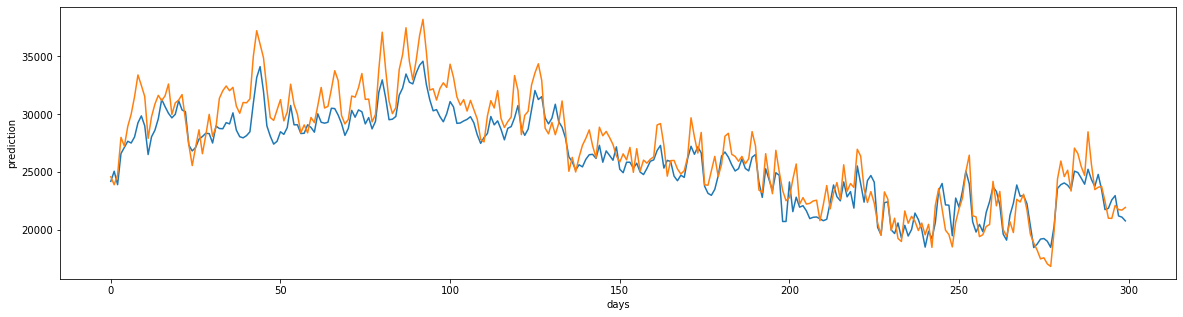

In [138]:
#plot real values 
plt.figure(figsize = (20,5))
plt.plot(predicted)
plt.plot(actuals)
plt.xlabel("days")
plt.ylabel("prediction")

plt.show()

## Hyperparameter adjustment 

In [65]:
#optimize hyperparameter 
error = []
for i in range(1,150,1):
    #run neural network model 
    regr = MLPRegressor([i],validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    nn_pred = regr.predict(X_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    error.append(RMSE)


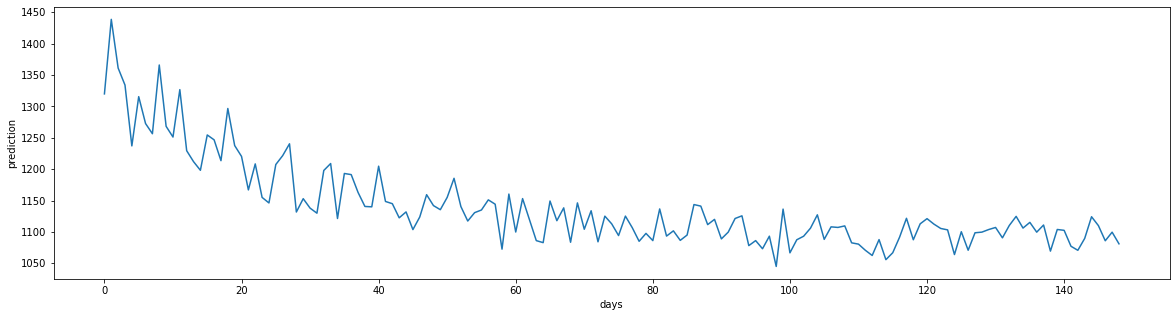

In [27]:
y = error
x = range(1,200,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

In [28]:
error = []
for i in range(1,50,1):
    #run neural network model 
    regr = MLPRegressor(hidden_layer_sizes = (112,i),validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    nn_pred = regr.predict(X_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    error.append(RMSE)

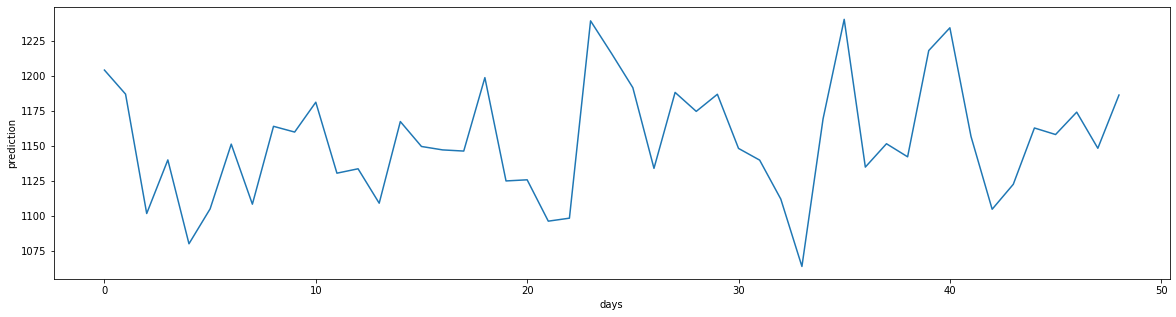

In [29]:
y = error
x = range(1,200,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

# Test with last different datapoints

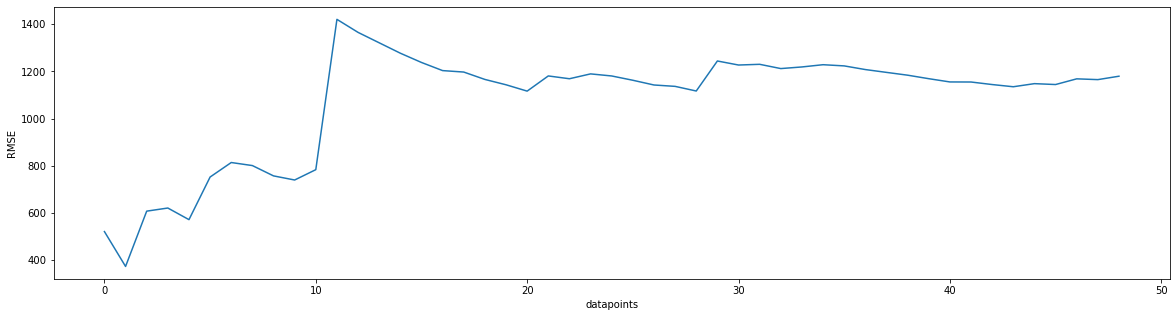

In [82]:
L = []
for i in range(1,50,1):    
    #run neural network model 
    regr = MLPRegressor(hidden_layer_sizes = (112) ,validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    #short term prediction
    n5_test = X_test.tail(n=i)
    n5_result = y_test.tail(n=i)
    #predict
    nn_pred = regr.predict(n5_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    L.append(RMSE)
    
y = L
x = range(1,50,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("datapoints")
plt.ylabel("RMSE")
plt.show()

In [78]:
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 

In [79]:
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1143.1417620277368


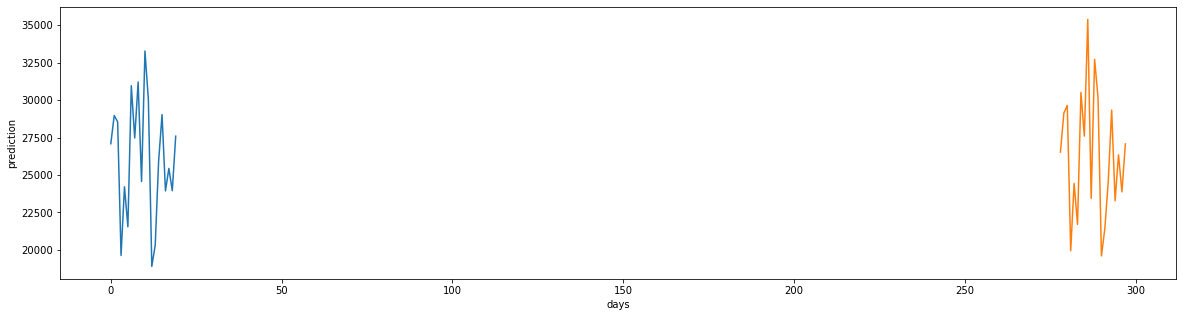

In [80]:
#plot real values 
plt.figure(figsize = (20,5))
plt.plot(predicted)
plt.plot(actuals)
plt.xlabel("days")
plt.ylabel("prediction")

plt.show()

# First round game prediction

In [165]:

regr = MLPRegressor(hidden_layer_sizes = (112) ,validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
#short term prediction
n5_test = X_test.tail(n=1)
n5_result = y_test.tail(n=1)
#predict
nn_pred = regr.predict(n5_test)
#drop index
y_test.reset_index(drop=True, inplace=True) 
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print('Error')
print(RMSE)
print('Prediction')
print(predicted)
print('')




Error
1685.615500208798
Prediction
[20270.88663229]

4243.385695985998


In [125]:
fulldf.tail(n=10)

,Leeds,stringency_index,avg_sun,Leeds,avg_temp,value,values-1,values-7,month,quadratic,day,values-2,values-3,values-4,values-5,values-6,values-14,values-30
2021-02-27,578.52905,0.0,640.202825,6.309329,8.070879,25298.541667,27969.895833,24244.979167,2,5.878190e+08,27,27877.937500,26284.166667,26380.062500,29187.854167,26082.500000,30293.166667,30069.291667
2021-02-28,594.69556,0.0,650.955425,6.409328,6.373526,25294.750000,25298.541667,26082.500000,2,6.802968e+08,28,27969.895833,27877.937500,26284.166667,26380.062500,29187.854167,29346.791667,29097.208333
2021-03-01,459.48367,0.0,357.849832,4.839329,5.172722,29467.750000,25294.750000,29187.854167,3,8.519308e+08,1,25298.541667,27969.895833,27877.937500,26284.166667,26380.062500,30626.708333,27538.687500
2021-03-02,347.80000,0.0,449.110123,3.041829,4.942451,30112.625000,29467.750000,26380.062500,3,6.959077e+08,2,25294.750000,25298.541667,27969.895833,27877.937500,26284.166667,29497.229167,29346.187500
2021-03-03,0.00000,0.0,5.597931,3.026828,5.818560,31165.583333,30112.625000,26284.166667,3,6.908574e+08,3,29467.750000,25294.750000,25298.541667,27969.895833,27877.937500,28995.354167,32514.437500
2021-03-04,134.61206,0.0,17.594436,4.396828,5.689798,30915.812500,31165.583333,27877.937500,3,7.771794e+08,4,30112.625000,29467.750000,25294.750000,25298.541667,27969.895833,27834.666667,30862.270833
2021-03-05,247.85887,0.0,498.102327,3.949329,4.002804,30367.833333,30915.812500,27969.895833,3,7.823151e+08,5,31165.583333,30112.625000,29467.750000,25294.750000,25298.541667,28094.479167,30809.645833
2021-03-06,540.63434,0.0,398.263598,3.904329,3.515665,27862.083333,30367.833333,25298.541667,3,6.400162e+08,6,30915.812500,31165.583333,30112.625000,29467.750000,25294.750000,24244.979167,31410.187500
2021-03-07,650.92270,0.0,622.284586,4.184328,3.425901,27075.104170,27862.083333,25294.750000,3,6.398244e+08,7,30367.833333,30915.812500,31165.583333,30112.625000,29467.750000,26082.500000,30231.166667
2021-03-08,85.22076,0.0,161.965383,6.001828,5.793223,NaN,27075.104170,29467.750000,3,8.683483e+08,8,27862.083333,30367.833333,30915.812500,31165.583333,30112.625000,29187.854167,27886.708333


299   -0.262756
Name: 3, dtype: float64